In [ ]:

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42


In [ ]:

df = pd.read_csv('/content/heart_disease.csv')   # path used earlier
print("Shape:", df.shape)
display(df.head())
print("\nInfo:")
df.info()
print("\nMissing values per column:\n", df.isna().sum())
print("\nTarget distribution:")
print(df['target'].value_counts(), "\n(0 = no disease, 1 = disease)")


Shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB

Missing values per column:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
t

In [ ]:

X = df.drop(columns=['target'])
y = df['target']

# Keep a hold-out test set for final evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))


Train shape: (242, 13) Test shape: (61, 13)
Train target distribution:
 target
1    0.545455
0    0.454545
Name: proportion, dtype: float64
Test target distribution:
 target
1    0.540984
0    0.459016
Name: proportion, dtype: float64


In [ ]:

def evaluate_model(y_true, y_pred, label="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    print(f"=== {label} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("Confusion matrix:\n", cm)
    print("\nClassification report:\n", classification_report(y_true, y_pred, zero_division=0))
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'cm': cm}


In [ ]:

knn_baseline = KNeighborsClassifier(n_neighbors=5)
knn_baseline.fit(X_train, y_train)
y_pred_baseline = knn_baseline.predict(X_test)

results_baseline = evaluate_model(y_test, y_pred_baseline, label="KNN (k=5) — No normalization")


=== KNN (k=5) — No normalization ===
Accuracy : 0.5902
Precision: 0.6250
Recall   : 0.6061
F1-score : 0.6154
Confusion matrix:
 [[16 12]
 [13 20]]

Classification report:
               precision    recall  f1-score   support

           0       0.55      0.57      0.56        28
           1       0.62      0.61      0.62        33

    accuracy                           0.59        61
   macro avg       0.59      0.59      0.59        61
weighted avg       0.59      0.59      0.59        61



Best k without normalization (by CV accuracy): 6


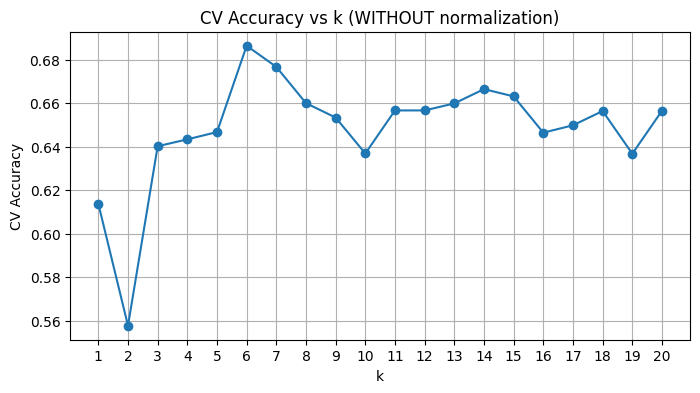

In [ ]:

k_range = list(range(1, 21))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_scores_unnorm = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')  # use whole X with CV
    cv_scores_unnorm.append(scores.mean())

# best k
best_k_unnorm = k_range[int(np.argmax(cv_scores_unnorm))]
print(f"Best k without normalization (by CV accuracy): {best_k_unnorm}")

# Plot
plt.figure(figsize=(8,4))
plt.plot(k_range, cv_scores_unnorm, marker='o')
plt.title("CV Accuracy vs k (WITHOUT normalization)")
plt.xlabel("k")
plt.ylabel("CV Accuracy")
plt.xticks(k_range)
plt.grid(True)
plt.show()


In [ ]:

knn_unnorm_best = KNeighborsClassifier(n_neighbors=best_k_unnorm)
knn_unnorm_best.fit(X_train, y_train)
y_pred_unnorm_best = knn_unnorm_best.predict(X_test)

results_unnorm_best = evaluate_model(y_test, y_pred_unnorm_best, label=f"KNN (k={best_k_unnorm}) — No normalization")


=== KNN (k=6) — No normalization ===
Accuracy : 0.5738
Precision: 0.6207
Recall   : 0.5455
F1-score : 0.5806
Confusion matrix:
 [[17 11]
 [15 18]]

Classification report:
               precision    recall  f1-score   support

           0       0.53      0.61      0.57        28
           1       0.62      0.55      0.58        33

    accuracy                           0.57        61
   macro avg       0.58      0.58      0.57        61
weighted avg       0.58      0.57      0.57        61



In [ ]:
# Cell 8: Fit scaler on training data, transform both train & test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# show effect for a couple of columns
pd.DataFrame({
    'age_train_raw_min': X_train['age'].min(),
    'age_train_raw_max': X_train['age'].max(),
    'age_train_scaled_min': X_train_scaled[:, X.columns.get_loc('age')].min(),
    'age_train_scaled_max': X_train_scaled[:, X.columns.get_loc('age')].max(),
}, index=[0]).T


,0
age_train_raw_min,29.000000
age_train_raw_max,77.000000
age_train_scaled_min,-2.768578
age_train_scaled_max,2.486291


Best k WITH normalization (by CV accuracy): 18


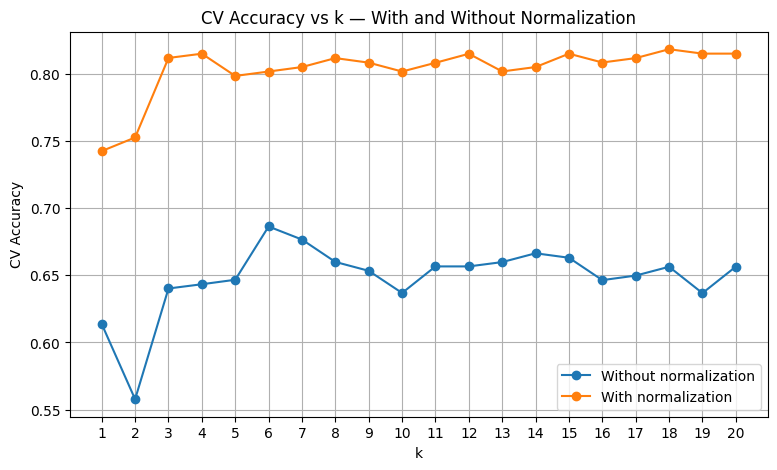

In [ ]:
# Cell 9: CV to find best k WITH normalization (Pipeline ensures scaling inside CV)
from sklearn.pipeline import Pipeline

cv_scores_norm = []
for k in k_range:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    cv_scores_norm.append(scores.mean())

best_k_norm = k_range[int(np.argmax(cv_scores_norm))]
print(f"Best k WITH normalization (by CV accuracy): {best_k_norm}")

# Plot both curves together for comparison
plt.figure(figsize=(9,5))
plt.plot(k_range, cv_scores_unnorm, marker='o', label='Without normalization')
plt.plot(k_range, cv_scores_norm, marker='o', label='With normalization')
plt.title("CV Accuracy vs k — With and Without Normalization")
plt.xlabel("k")
plt.ylabel("CV Accuracy")
plt.xticks(k_range)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Cell 10: Train final model on scaled training data using best_k_norm
knn_norm_best = KNeighborsClassifier(n_neighbors=best_k_norm)
knn_norm_best.fit(X_train_scaled, y_train)
y_pred_norm_best = knn_norm_best.predict(X_test_scaled)

results_norm_best = evaluate_model(y_test, y_pred_norm_best, label=f"KNN (k={best_k_norm}) — With normalization")


=== KNN (k=18) — With normalization ===
Accuracy : 0.8197
Precision: 0.7750
Recall   : 0.9394
F1-score : 0.8493
Confusion matrix:
 [[19  9]
 [ 2 31]]

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.68      0.78        28
           1       0.78      0.94      0.85        33

    accuracy                           0.82        61
   macro avg       0.84      0.81      0.81        61
weighted avg       0.83      0.82      0.82        61



In [ ]:
# Cell 11: Comparison
summary = pd.DataFrame([
    {'Model': 'KNN k=5 (no norm)', **results_baseline},
    {'Model': f'KNN k={best_k_unnorm} (no norm)', **results_unnorm_best},
    {'Model': f'KNN k={best_k_norm} (with norm)', **results_norm_best}
])

# Keep numeric columns only (accuracy, precision, recall, f1)
summary_display = summary[['Model', 'accuracy', 'precision', 'recall', 'f1']]
summary_display = summary_display.set_index('Model')
display(summary_display.round(4))


,accuracy,precision,recall,f1
Model,,,,
KNN k=5 (no norm),0.5902,0.6250,0.6061,0.6154
KNN k=6 (no norm),0.5738,0.6207,0.5455,0.5806
KNN k=18 (with norm),0.8197,0.7750,0.9394,0.8493


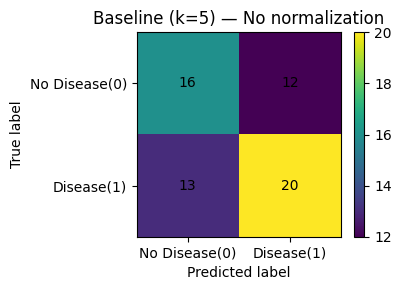

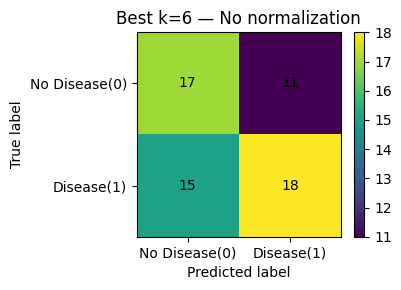

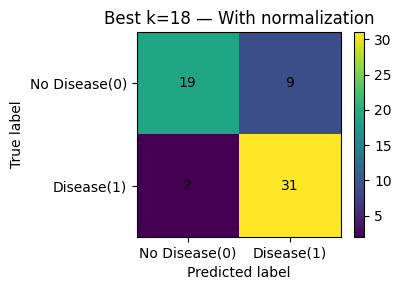

In [ ]:
# Cell 12: Plot confusion matrices
def plot_confusion(cm, title="Confusion matrix"):
    plt.figure(figsize=(4,3))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No Disease(0)','Disease(1)'])
    plt.yticks(tick_marks, ['No Disease(0)','Disease(1)'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Baseline confusion
plot_confusion(results_baseline['cm'], "Baseline (k=5) — No normalization")

# Best unnormalized confusion
plot_confusion(results_unnorm_best['cm'], f"Best k={best_k_unnorm} — No normalization")

# Best normalized confusion
plot_confusion(results_norm_best['cm'], f"Best k={best_k_norm} — With normalization")


In [ ]:
# Cell 13: Save summary to CSV (optional)
summary_display.to_csv('knn_heart_summary.csv')
print("Saved summary to knn_heart_summary.csv")

# Observations (print a short summary)
print("\nQuick observations:")
print("- Normalization often improves KNN because KNN uses distances; features with larger scale dominate otherwise.")
print("- Optimal k can change with normalization. Use CV (stratified) to choose k robustly.")
print("- Compare confusion matrices and recall/precision based on the metric you care most about (e.g., recall if missing disease is costly).")


Saved summary to knn_heart_summary.csv

Quick observations:
- Normalization often improves KNN because KNN uses distances; features with larger scale dominate otherwise.
- Optimal k can change with normalization. Use CV (stratified) to choose k robustly.
- Compare confusion matrices and recall/precision based on the metric you care most about (e.g., recall if missing disease is costly).
